In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os, re, sys
from sklearn.model_selection import train_test_split

In [2]:
# test if GPUs are available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# set project root, maybe you need to firstly 
# add shortcut of CS 766 Project to drive.
project_root = './drive/MyDrive/CS 766 Project/Project Coding and Data Files'

In [17]:
# class to initialize CNNs
class OriginCNN(object):
  """docstring for OriginCNN"""
  def __init__(self):
    self.optimizer = 'adam'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # will add more properties


  def build(self):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides=(3,3), activation='relu', input_shape=(224, 224, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), strides=(3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), strides=(3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(2))

    model.summary()
    model.compile(optimizer=self.optimizer,
                loss=self.loss,
                metrics=['accuracy'])
    self.model = model


  def train(self, train_images, train_labels, test_images, test_labels, epochs):
    self.history = self.model.fit(train_images, train_labels, epochs=epochs, 
        validation_data=(test_images, test_labels))


  def evaluate(self, test_images, test_labels):
    plt.plot(self.history.history['accuracy'], label='accuracy')
    plt.plot(self.history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    test_loss, test_acc = self.model.evaluate(test_images, test_labels, verbose=2)

    print(test_acc)

# this cnn is for testing
class OriginCNN_cifar(object):
  """docstring for OriginCNN"""
  def __init__(self):
    self.optimizer = 'adam'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # will add more properties

  # this method is for cifar dataset, I used it for testing and debugging
  def build(self):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))

    model.summary()
    model.compile(optimizer=self.optimizer,
                loss=self.loss,
                metrics=['accuracy'])
    self.model = model


  def train(self, train_images, train_labels, test_images, test_labels, epochs):
    self.history = self.model.fit(train_images, train_labels, epochs=epochs, 
        validation_data=(test_images, test_labels))


  def evaluate(self, test_images, test_labels):
    plt.plot(self.history.history['accuracy'], label='accuracy')
    plt.plot(self.history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    test_loss, test_acc = self.model.evaluate(test_images, test_labels, verbose=2)

    print(test_acc)

In [31]:
# classes to load data
class Cifar10(object):
  """docstring for OriginCNN"""
  def __init__(self):
    # cifar10 is used for debugging
    (train_images, self.train_labels), (test_images, self.test_labels) = datasets.cifar10.load_data()

    # Normalize pixel values to be between 0 and 1
    self.train_images, self.test_images = train_images / 255.0, test_images / 255.0

class DR_resized(object):
  """docstring for DR_resized"""
  def __init__(self):
    # all_images = np.load("Data Batches/Xtrain_Batch0.npy", allow_pickle=True)
    # all_labels = np.load("Data Batches/Ytrain_Batch0.npy", allow_pickle=True)
    # print(all_images.shape)
    # print(all_labels.shape)
    # self.train_images = np.load("Data Batches/Xtrain_Batch0.npy", allow_pickle=True)
    # self.train_labels = np.load("Data Batches/Ytrain_Batch0.npy")
    # self.test_images = np.load("Data Batches/Xtest_Batch.npy")
    # self.test_labels = np.load("Data Batches/Ytest_Batch.npy")
    # print(type(self.train_images))
    image_list = []
    label_list = []
    image_num = 100
    for i in range(image_num):
        img = np.random.rand(224, 224)
        label = 0 if np.random.random() > 0.5 else 1
        image_list.append(img)
        label_list.append(label)
    
    all_images = np.array(image_list)
    all_images = np.reshape(all_images, (image_num, 224, 224, 1))
    all_label = np.array(label_list)
    
    self.train_images, self.test_images, self.train_labels, self.test_labels \
    = train_test_split(all_images, all_label, test_size=0.2, random_state=9876)




In [18]:
myModel = OriginCNN()

In [19]:
myModel

In [32]:
myData = DR_resized()

In [33]:
myModel.build()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 74, 74, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 32)          9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)               

In [35]:
myModel.train(myData.train_images, myData.train_labels, myData.test_images, myData.test_labels, 100)

Epoch 1/100
3/3 [==============================] - 0s 45ms/step - loss: 0.6664 - accuracy: 0.5250 - val_loss: 0.7289 - val_accuracy: 0.3000
Epoch 2/100
3/3 [==============================] - 0s 25ms/step - loss: 0.6663 - accuracy: 0.5250 - val_loss: 0.7208 - val_accuracy: 0.3000
Epoch 3/100
3/3 [==============================] - 0s 26ms/step - loss: 0.6582 - accuracy: 0.7375 - val_loss: 0.6847 - val_accuracy: 0.7500
Epoch 4/100
3/3 [==============================] - 0s 24ms/step - loss: 0.6557 - accuracy: 0.9625 - val_loss: 0.6905 - val_accuracy: 0.7000
Epoch 5/100
3/3 [==============================] - 0s 27ms/step - loss: 0.6491 - accuracy: 0.9875 - val_loss: 0.7142 - val_accuracy: 0.3000
Epoch 6/100
3/3 [==============================] - 0s 25ms/step - loss: 0.6430 - accuracy: 0.7500 - val_loss: 0.7263 - val_accuracy: 0.3000
Epoch 7/100
3/3 [==============================] - 0s 25ms/step - loss: 0.6391 - accuracy: 0.7250 - val_loss: 0.7196 - val_accuracy: 0.3000
Epoch 8/100
3/3 [===

1/1 - 0s - loss: 0.9452 - accuracy: 0.3500
0.3499999940395355


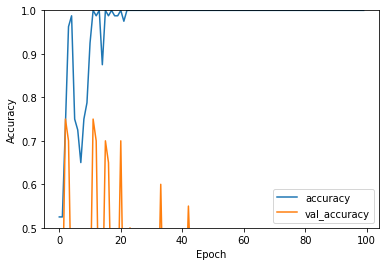

In [36]:
myModel.evaluate(myData.test_images, myData.test_labels)